# Network Analysis

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

Create user user_id list from preprocessed data

In [2]:
data = pd.read_csv('../output/preprocessed.csv')

user_dict = {}

# Function to add a user ID to a username
def add_user_id(username, user_id):
    if username in user_dict:
        user_dict[username].append(user_id)
    else:
        user_dict[username] = [user_id]

for index, row in data.iterrows():
    add_user_id(row['user'], row['user_id'])

{k: user_dict[k] for k in list(user_dict)[:5]}

{'danielwoodard': [1077866112],
 'nelsonjacqueline': [1089670430],
 'ihooper': [1007478642, 1007478642],
 'wrightnicholas': [1039258480],
 'michael51': [1021455936, 1096712805, 1022492390]}

In [3]:
# Create a new column 'user' in data by mapping user_id to user using user_id_dict
data['user'] = data['user_id'].map({v: k for k, v_list in user_dict.items() for v in v_list})
data.head()

,timestamp,text,text_id,user,user_id,hashtags,mentions,frequency,language
0,00:00:00,run business mean juggle countless administrat...,2018569761,danielwoodard,1077866112,"['#HRtech', '#businessmanagement']",[],1,en
1,00:00:00,liz truss walk linger shadow predecessor charl...,2092717718,nelsonjacqueline,1089670430,['#politics'],[],1,en
2,00:00:00,uk brace war government building london raise ...,2059143248,ihooper,1007478642,"['#Ukrainewashed', '#WarPreparedness']",[],1,en
3,00:00:00,marry second cousin remove taboo think genetic...,2008209828,wrightnicholas,1039258480,"['#FamilyTree', '#GeneticFacts']",[],1,en
4,00:00:00,truly disgraceful indian national congress sto...,2001239278,michael51,1021455936,['#RationChorCongress'],[],1,en


In [4]:
# Create a new dataframe with non-empty mentions
data_mentions = data[data['mentions'].apply(lambda x: len(eval(x)) > 0)][['user', 'mentions']]
print(f"Number of posts with mentions: {len(data_mentions)}")
data_mentions.head()

Number of posts with mentions: 35322


,user,mentions
5,ihooper,"['gabrieltaylor', 'lori57', 'timothy62', 'andr..."
7,mark89,"['mckenzieestrada', 'mckenzieestrada', 'shane2..."
8,andrea21,['jonathanreynolds']
10,kimberly05,['bethanycarroll']
11,kristen10,['wdavis']


In [5]:
# Load the graph data
graph_data = pd.read_csv('../data/graph.csv')

# Flatten the list of user IDs from user_dict
user_ids = set([user_id for user_ids in user_dict.values() for user_id in user_ids])

# Check if any user ID in the graph.csv is not in the user relation list
missing_users_set = set(graph_data['source']).union(set(graph_data['target'])) - user_ids

# Convert the set of missing users to a DataFrame
missing_users = pd.DataFrame(list(missing_users_set), columns=['user_id'])

print(f"Number of missing users: {len(missing_users)}")

Number of missing users: 717


In [6]:
missing_users

,user_id
0,1005090817
1,1046982657
2,8181721092
3,1048807428
4,1192646665
...,...
712,1036550138
713,1049909243
714,1083273212
715,1027194877


In [7]:
initial_row_count = len(graph_data)

# Filter out rows where source or target is in missing_users_set
graph_data = graph_data[~graph_data['source'].isin(missing_users_set) & ~graph_data['target'].isin(missing_users_set)]

filtered_row_count = len(graph_data)

print(f"Number of removed rows: {initial_row_count - filtered_row_count}")

Number of removed rows: 2880


In [8]:
data['user'] = data['user_id'].map({v: k for k, v_list in user_dict.items() for v in v_list})
# Create a new dataframe by mapping both source and target columns
graph_data['source'] = graph_data['source'].map({v: k for k, v_list in user_dict.items() for v in v_list})
graph_data['target'] = graph_data['target'].map({v: k for k, v_list in user_dict.items() for v in v_list})
graph_data.head()

,source,target,weight
0,eleonard,jamessimon,1
1,eleonard,brianna65,1
2,eleonard,yschmidt,1
5,eleonard,amanda97,1
6,eleonard,rosariohannah,1


In [9]:
len(graph_data)

92004

In [10]:
non_empty_mentions_count = data[data['mentions'].apply(lambda x: len(eval(x)) > 0)].shape[0]
print(f"Number of rows in data with non-empty mentions: {non_empty_mentions_count}")

Number of rows in data with non-empty mentions: 35322


### Mentions (directed)

In [11]:
# Create a directed graph
mentioning_graph = nx.DiGraph()

# Add edges to the graph based on mentions
for index, row in data_mentions.iterrows():
    user = row['user']
    mentions = eval(row['mentions'])
    for mentioned_user in mentions:
        mentioning_graph.add_edge(user, mentioned_user)

# Print the number of nodes and edges in the mentioning graph
print(f"Number of nodes in the mentioning graph: {mentioning_graph.number_of_nodes()}")
print(f"Number of edges in the mentioning graph: {mentioning_graph.number_of_edges()}")

Number of nodes in the mentioning graph: 53179
Number of edges in the mentioning graph: 88158


In [12]:
# Compute in-degree centrality for the mentioning graph (directed)
in_degree_centrality_mentions = nx.in_degree_centrality(mentioning_graph)

### Followers (undirected)

In [13]:
# Create an undirected graph
following_graph = nx.Graph()

# Add edges to the graph
for index, row in graph_data.iterrows():
        following_graph.add_edge(row['source'], row['target'], weight=row['weight'])

# Print the number of nodes and edges in the graph
print(f"Number of nodes: {following_graph.number_of_nodes()}")
print(f"Number of edges: {following_graph.number_of_edges()}")

Number of nodes: 37241
Number of edges: 91969


In [14]:
# Compute degree centrality for the following graph (undirected)
degree_centrality_following = nx.degree_centrality(following_graph)

In [15]:
# Create a MultiDiGraph
combined_graph = nx.MultiDiGraph()

# Add edges from the following graph
for u, v, data in following_graph.edges(data=True):
    combined_graph.add_edge(u, v, key='following', **data)

# Add edges from the mentioning graph
for u, v, data in mentioning_graph.edges(data=True):
    combined_graph.add_edge(u, v, key='mentioning', **data)

# Print the number of nodes and edges in the combined graph
print(f"Number of nodes in the combined graph: {combined_graph.number_of_nodes()}")
print(f"Number of edges in the combined graph: {combined_graph.number_of_edges()}")

Number of nodes in the combined graph: 64879
Number of edges in the combined graph: 180127


In [16]:
# Combine the scores to rank influential users
combined_centrality = {}
for user in set(degree_centrality_following.keys()).union(in_degree_centrality_mentions.keys()):
    combined_centrality[user] = degree_centrality_following.get(user, 0) + in_degree_centrality_mentions.get(user, 0)

# Sort users by combined centrality score in descending order
ranked_influential_users = sorted(combined_centrality.items(), key=lambda item: item[1], reverse=True)

# Print top 10 influential users
top_10_influential_users = ranked_influential_users[:100]
print("Top 100 influential users:")
for user, score in top_10_influential_users:
    print(f"{user}: {score}")

Top 100 influential users:
yhawkins: 0.06185422434085246
robert78: 0.046850168893486595
randy35: 0.011151227951408478
greilly: 0.008443341231336268
kimberly95: 0.006506450035729061
mflores: 0.0041556983963915205
mckenzieestrada: 0.0034788822445372147
ericbarnes: 0.0030839820978600173
ortizjane: 0.0029899582534130657
fdoyle: 0.0029576881792818793
zsmith: 0.0029163590945740104
wardalison: 0.0028019105645191622
wsmith: 0.002618346934372245
chaddiaz: 0.0024167561761546724
qlewis: 0.002412349881489559
drodriguez: 0.002377293429411765
rharris: 0.0023657590972159695
tclark: 0.002293248635523142
melinda91: 0.002013963480128894
ismith: 0.002003284552833705
kennethbrennan: 0.001993305502275377
timothy45: 0.001979062556214847
djohnson: 0.0019500454445215082
nsmith: 0.0019388999327350793
imorgan: 0.001901212630874425
stephensonrachael: 0.0018428673511602543
mark96: 0.0018287021691815975
fsmith: 0.0017859086959189693
michael59: 0.001766948398865832
ksmith: 0.001761686699300111
maria72: 0.0017112339

In [17]:
# Apply Louvain to the undirected following_graph
partition_following = nx.algorithms.community.louvain_communities(following_graph)

# Convert mentioning_graph to undirected for Louvain
mention_graph_undirected = mentioning_graph.to_undirected()
partition_mention = nx.algorithms.community.louvain_communities(mention_graph_undirected)

# Convert the partition lists to dictionaries for easier lookup
node_to_community_following = {}
for i, community in enumerate(partition_following):
	for node in community:
		node_to_community_following[node] = i

node_to_community_mention = {}
for i, community in enumerate(partition_mention):
	for node in community:
		node_to_community_mention[node] = i

In [18]:
# Simple comparison of how many nodes share the same community
shared_nodes = set(node_to_community_following.keys()).intersection(node_to_community_mention.keys())
same_community_count = sum(
	1 for node in shared_nodes 
	if node_to_community_following[node] == node_to_community_mention[node]
)

print(f"Number of communities in following: {len(partition_following)}")
print(f"Number of communities in mention: {len(partition_mention)}")
print(f"Number of nodes in the same community across both graphs: {same_community_count}")
print(f"Total shared nodes: {len(shared_nodes)}")

Number of communities in following: 95
Number of communities in mention: 2061
Number of nodes in the same community across both graphs: 40
Total shared nodes: 25541


In [19]:
from collections import Counter

# Count the number of members in each community
counts = Counter({i: len(community) for i, community in enumerate(partition_following)})
sorted_communities = counts.most_common()

# Print the top 5 communities by size
for comm_id, size in sorted_communities[:5]:
    print(f"Community {comm_id} has {size} members")

Community 66 has 693 members
Community 46 has 639 members
Community 81 has 631 members
Community 0 has 630 members
Community 84 has 629 members


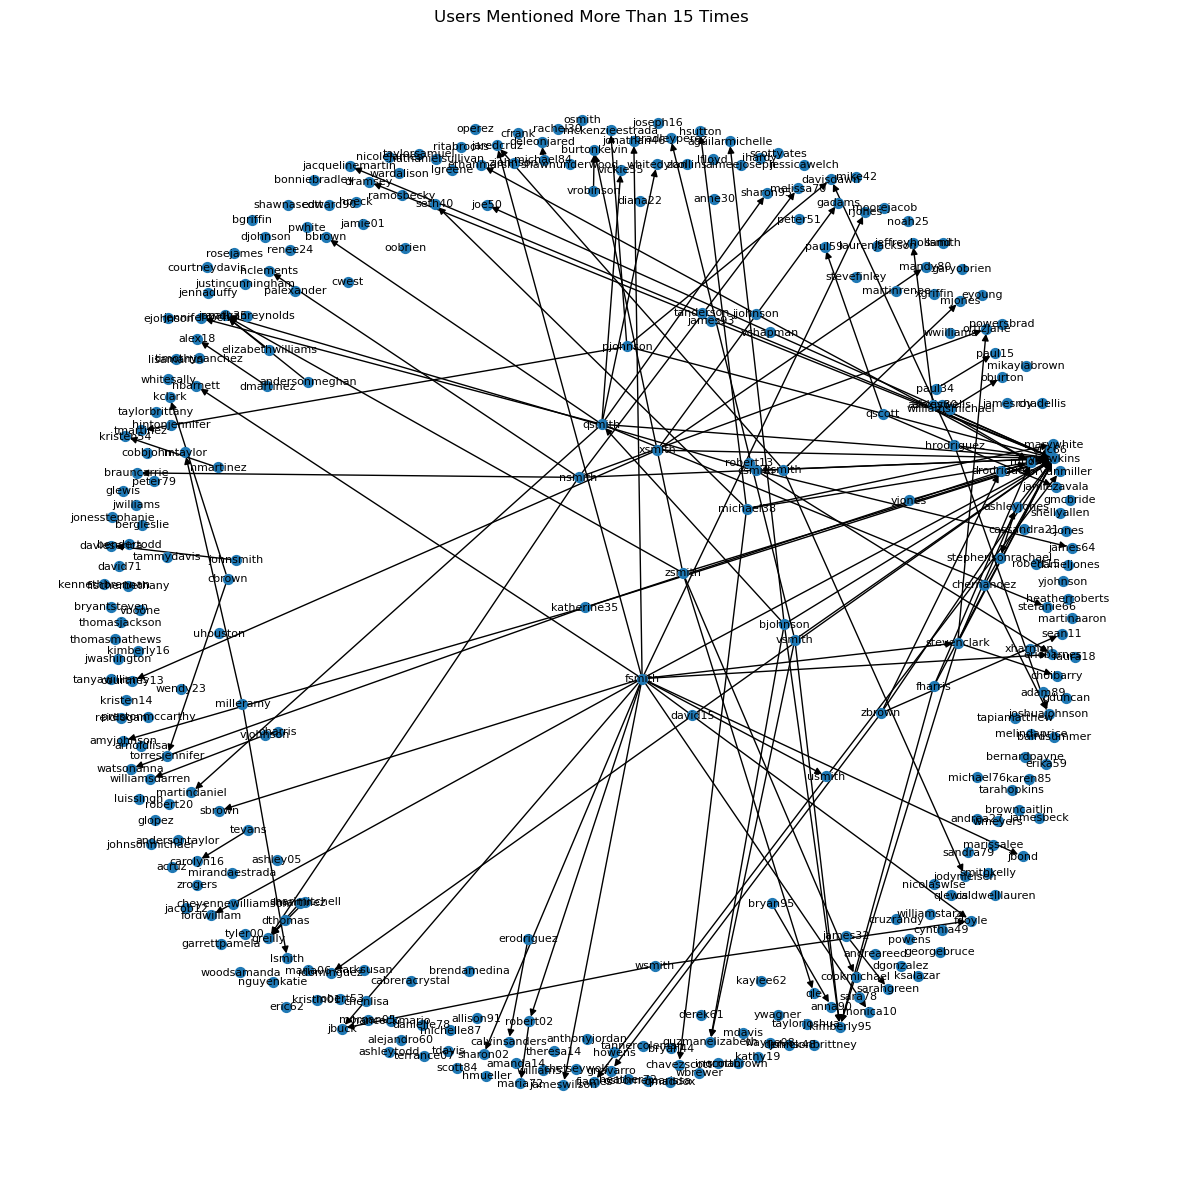

In [20]:
# Filter nodes with in-degree greater than 50
nodes_to_visualize = [node for node, in_degree in mentioning_graph.in_degree() if in_degree > 15]

# Create a subgraph with the filtered nodes
subgraph = mentioning_graph.subgraph(nodes_to_visualize)

# Generate positions for the nodes
pos = nx.spring_layout(subgraph)

# Draw the subgraph
plt.figure(figsize=(15, 15))
nx.draw_networkx(subgraph, pos, node_size=50, font_size=8, with_labels=True)
plt.title("Users Mentioned More Than 15 Times")
plt.axis("off")
plt.show()

In [21]:
# Create a dictionary to store the top users with the most followers in each community
top_users_by_community = {}

# Iterate over each community in partition_following
for community_index, community in enumerate(partition_following):
    # Filter the in-degree dictionary to include only nodes in the current community
    community_in_degree = {node: degree_centrality_following[node] for node in community if node in degree_centrality_following}
    
    # Find the user with the most followers in the current community
    if community_in_degree:
        top_user = max(community_in_degree, key=community_in_degree.get)
        top_users_by_community[community_index] = (top_user, community_in_degree[top_user])

# Print the top users with the most followers in each community
for community_index, (user, followers) in top_users_by_community.items():
    print(f"Community {community_index}: {user} with {followers} followers")

Community 0: michael59 with 0.0016917293233082707 followers
Community 1: erodriguez with 0.0011278195488721805 followers
Community 2: esmith with 0.0010741138560687433 followers
Community 3: brandonsmith with 0.0011278195488721805 followers
Community 4: ismith with 0.0018528464017185822 followers
Community 5: bsmith with 0.0011009667024704619 followers
Community 6: zachary66 with 0.0008861439312567133 followers
Community 7: lisajones with 0.0012083780880773362 followers
Community 8: nnash with 0.0015306122448979593 followers
Community 9: chaddiaz with 0.0024167561761546724 followers
Community 10: robertrice with 0.0009129967776584318 followers
Community 11: msmith with 0.0011815252416756176 followers
Community 12: heather51 with 0.0010472610096670246 followers
Community 13: kevin92 with 0.0013426423200859291 followers
Community 14: howardnichole with 0.0010472610096670246 followers
Community 15: meredith27 with 0.0006981740064446832 followers
Community 16: zsanchez with 0.0011815252416

/tmp/ipykernel_5705/393162831.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab20', len(partition_following))


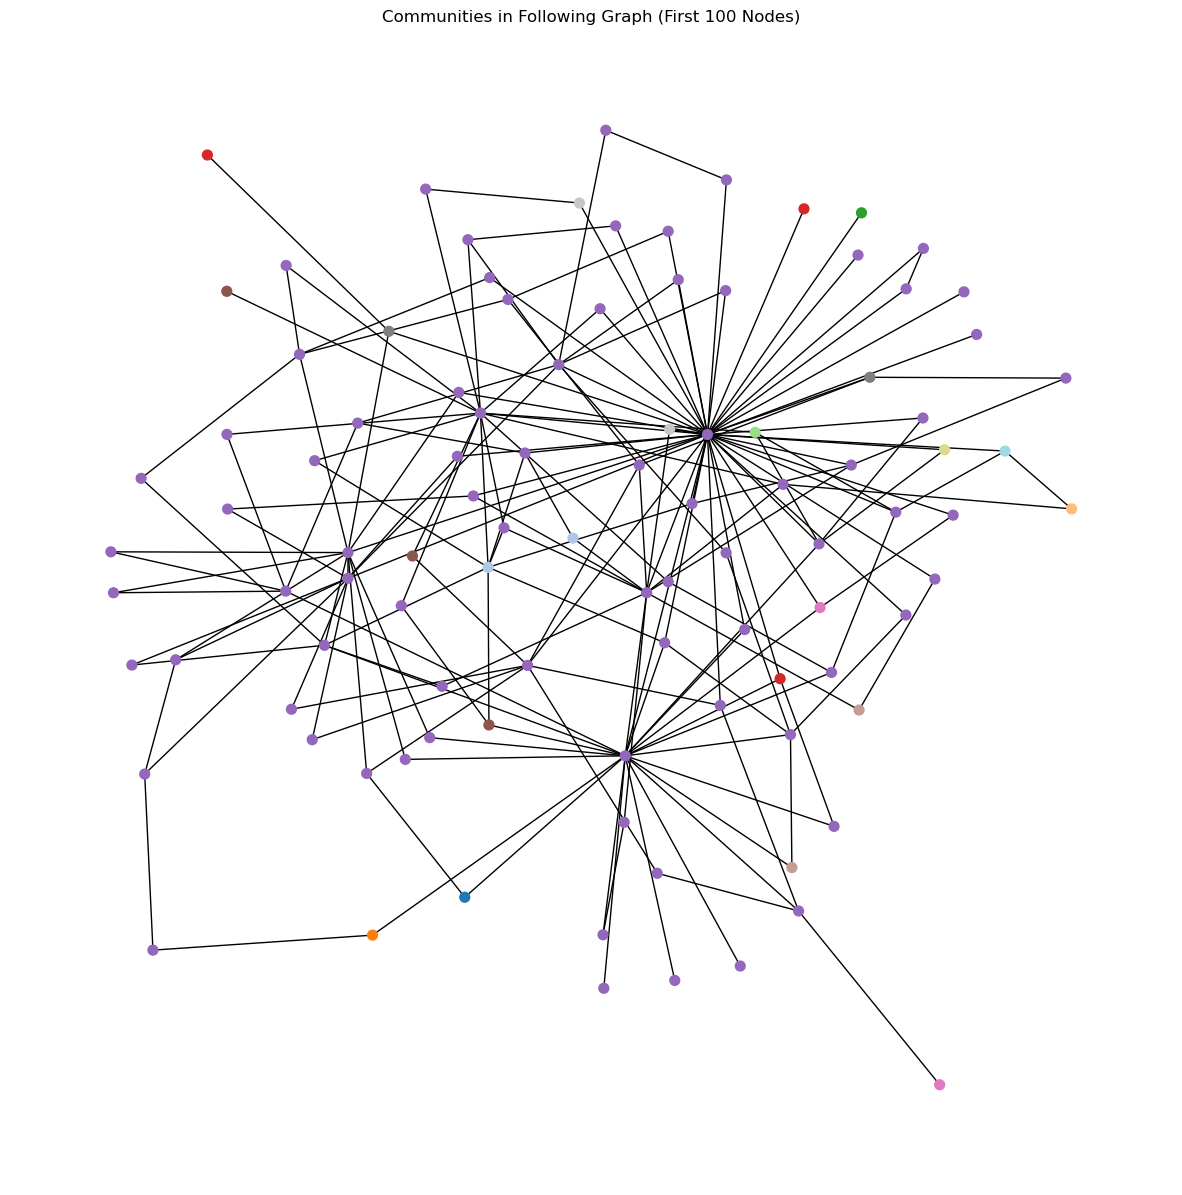

In [24]:
# Create a color map for the communities
color_map = plt.cm.get_cmap('tab20', len(partition_following))

# Create a dictionary to map each node to its community color
node_color_map = {}
for community_index, community in enumerate(partition_following):
    for node in community:
        node_color_map[node] = color_map(community_index)

# Take the first 100 nodes
nodes_to_visualize = list(following_graph.nodes())[:100]

# Generate positions for the nodes
pos = nx.spring_layout(following_graph.subgraph(nodes_to_visualize))

# Draw the graph with community colors
plt.figure(figsize=(15, 15))
nx.draw_networkx(following_graph.subgraph(nodes_to_visualize), pos, node_color=[node_color_map[node] for node in nodes_to_visualize], node_size=50, with_labels=False)
plt.title("Communities in Following Graph (First 100 Nodes)")
plt.axis("off")
plt.show()

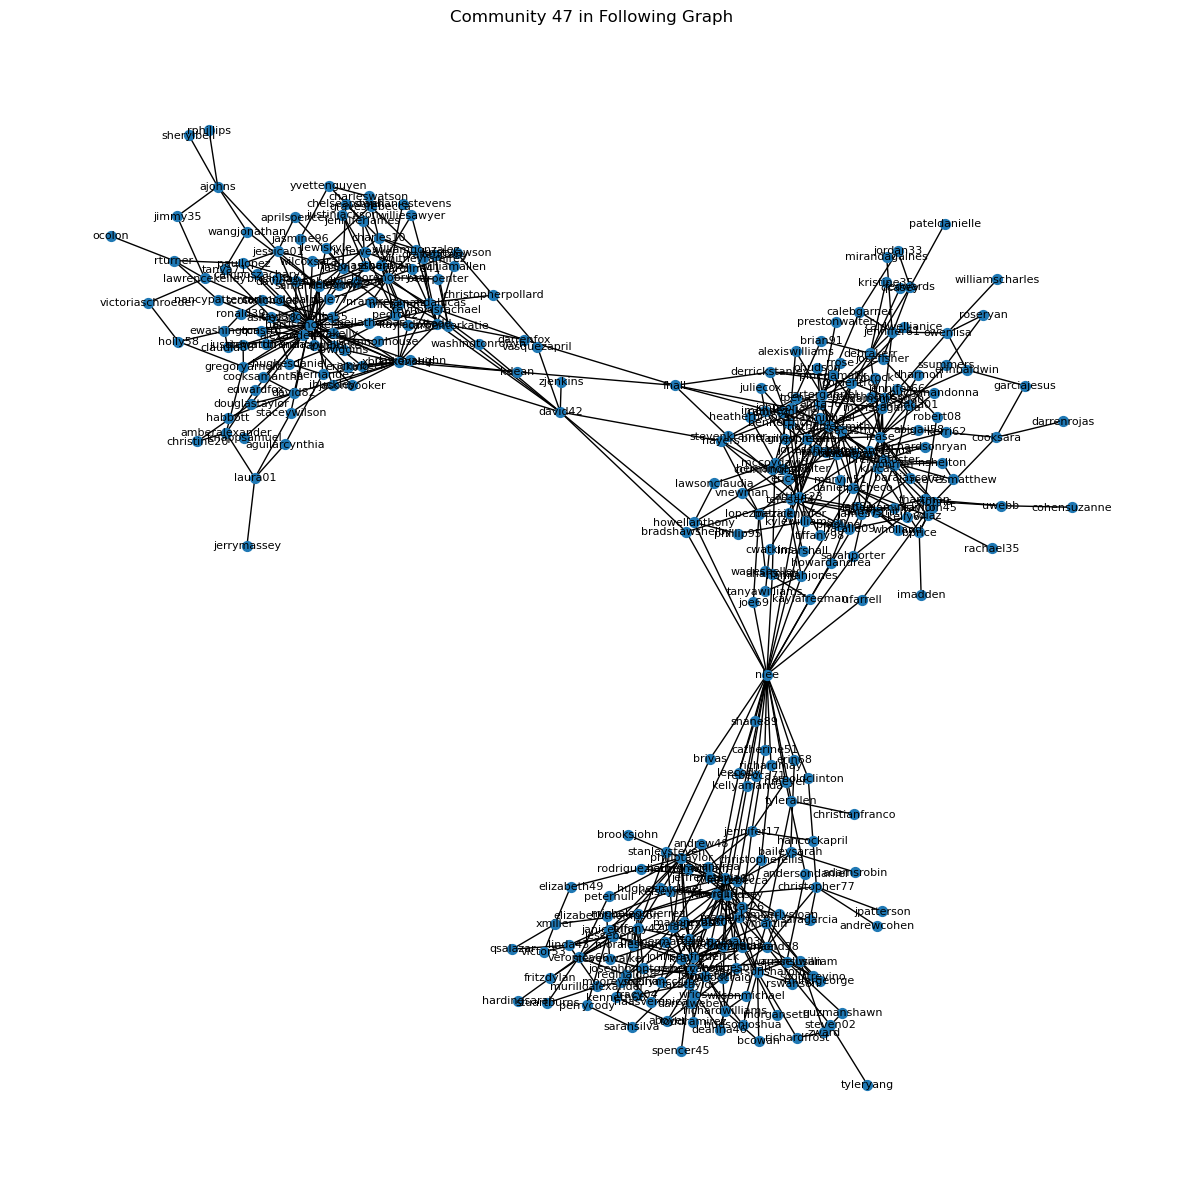

In [25]:
# Extract nodes in Community 47
community_47_nodes = partition_following[47]

# Create a subgraph for Community 47
community_47_subgraph = following_graph.subgraph(community_47_nodes)

# Draw the subgraph with a larger figure size
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(community_47_subgraph)
nx.draw_networkx(community_47_subgraph, pos, node_size=50, font_size=8, with_labels=True)
plt.title("Community 47 in Following Graph")
plt.axis("off")
plt.show()

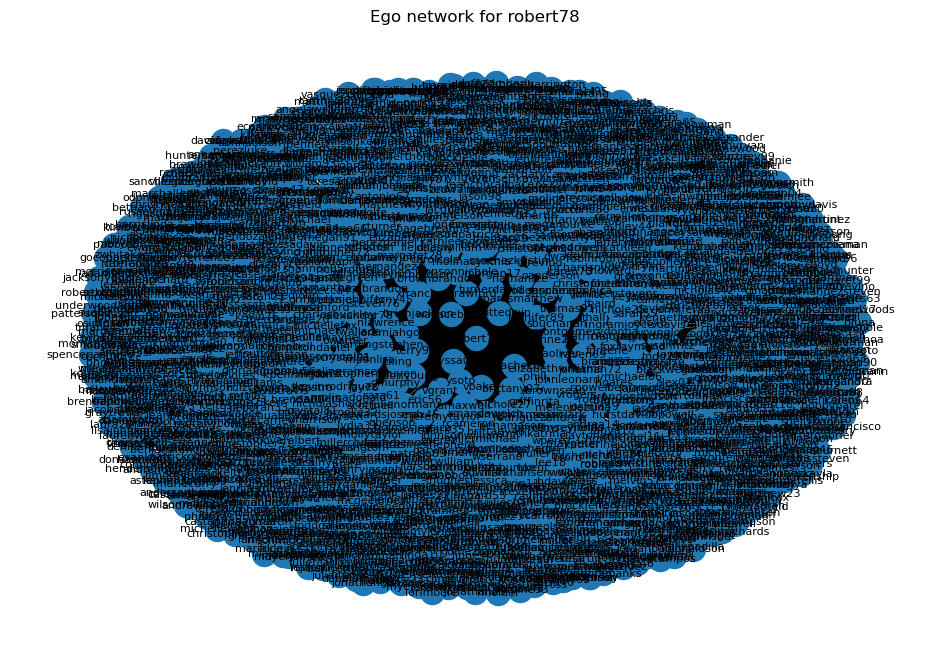

In [26]:
# Create an ego network for robert78
ego_network_robert78 = nx.ego_graph(following_graph, 'robert78', radius=1)

# Draw the ego network with a larger figure size
layout = nx.spring_layout(ego_network_robert78)
plt.figure(figsize=(12, 8))
nx.draw_networkx(ego_network_robert78, pos=layout, node_size=300, font_size=8, with_labels=True)
plt.title("Ego network for robert78")
plt.axis("off")
plt.show()